In [1]:
%pwd

'c:\\Users\\User\\Documents\\EndToEndMLProjects\\End-To-End-Machine-Learning-Project-with-MlFlow\\research'

In [2]:
import os

os.chdir('../')
%pwd

'c:\\Users\\User\\Documents\\EndToEndMLProjects\\End-To-End-Machine-Learning-Project-with-MlFlow'

# 1. Update config.yaml

# 2. Update the entity

In [3]:
from dataclasses import dataclass
from pathlib import Path

In [4]:
@dataclass(frozen=True)
class DataTransformationConfig:
    """
    Configuration class for data transformation in a machine learning pipeline.

    This dataclass holds paths for training and testing datasets, both features (X) 
    and labels (y), required during the data transformation process. The `frozen=True` 
    parameter ensures immutability of the configuration object.

    Attributes:
        root_dir (Path): The root directory for storing all data transformation outputs.
        X_train_data_path (str): Path to the file containing the training feature data.
        X_test_data_path (str): Path to the file containing the testing feature data.
        y_train_data_path (str): Path to the file containing the training labels.
        y_test_data_path (str): Path to the file containing the testing labels.
    """
    root_dir: Path
    X_train_data_path: str
    X_test_data_path: str
    y_train_data_path: str
    y_test_data_path: str
    

# 3. Update the configuration manager in src config

In [5]:
from mlproject.constants import *
from mlproject.utils.common import create_directories, read_yaml

In [6]:
class ConfigurationManager:
    """
    Manages the configuration and setup for the project.

    This class is responsible for reading configuration files, creating required directories, 
    and providing specific configuration objects needed for various components of the project.

    Attributes:
        config (dict): Parsed content of the main configuration file.
        params (dict): Parsed content of the parameters file.
    """
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH
        ) -> None:
        """
        Initializes the ConfigurationManager.

        Reads YAML configuration files for main configuration, parameters, and schema. 
        Also ensures that the root artifacts directory specified in the configuration is created.

        Args:
            config_filepath (str): Path to the main configuration YAML file. Default is `CONFIG_FILE_PATH`.
            params_filepath (str): Path to the parameters YAML file. Default is `PARAMS_FILE_PATH`.           
        """
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config.artifacts_root])
        
    def get_data_transformation_config(self) -> DataTransformationConfig:
        """
        Retrieves the configuration for the data transformation stage.

        - Reads the `data_transformation` section of the main configuration file.
        - Ensures that the root directory for data transformation outputs exists.
        - Creates and returns a `DataTransformationConfig` object with paths for training and testing datasets.

        Returns:
            DataTransformationConfig: An object containing paths and directories needed for data transformation.

        Raises:
            Exception: If any error occurs during configuration retrieval or directory creation.
        """
        try:
            config = self.config.data_transformation
            create_directories([config.root_dir])
            
            data_transformation_config = DataTransformationConfig(
                root_dir=config.root_dir,
                X_train_data_path=config.X_train_data_path,
                X_test_data_path=config.X_test_data_path,
                y_train_data_path=config.y_train_data_path,
                y_test_data_path=config.y_test_data_path
            )
            return data_transformation_config
        except Exception as e:
            raise e

# 4. Update the components

In [7]:
import pandas as pd
from typing import Tuple
from mlproject import logger
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN

In [8]:
class LabelEncoding:
    """
    Applies label encoding to target variables in the training and testing datasets.

    This class handles the transformation of categorical target labels into numeric form
    using scikit-learn's `LabelEncoder`. The transformed data is saved to the configured 
    output paths.

    Attributes:
        config (DataTransformationConfig): Configuration object containing paths for 
                                           saving the transformed target datasets.

    Methods:
        apply_label_encoding() -> Tuple[pd.Series, pd.Series]:
            Encodes the target labels in the training and testing datasets, saves them, 
            and returns the encoded series.
    """
    
    def __init__(self, config: DataTransformationConfig):
        """
        Initializes the LabelEncoding class.

        Args:
            config (DataTransformationConfig): Configuration object with file paths for 
                                               saving the transformed target datasets.
        """
        self.config = config
        
    def apply_label_encoding(self) -> Tuple[pd.Series, pd.Series]:
        """
        Applies label encoding to the target variables in the training and testing datasets.

        - Reads the target variables from CSV files.
        - Encodes the target variables using `LabelEncoder`.
        - Saves the transformed training and testing target variables to the configured paths.

        Returns:
            Tuple[pd.Series, pd.Series]: Encoded target variables for training and testing datasets.

        Raises:
            Exception: If any error occurs during label encoding or file operations.
        """
        try:
            y_train = pd.read_csv('artifacts/data_split/y_train.csv').iloc[:, 0]
            y_test = pd.read_csv('artifacts/data_split/y_test.csv').iloc[:, 0]
            
            labelEncoder = LabelEncoder()

            y_train = labelEncoder.fit_transform(y_train)
            y_test = labelEncoder.transform(y_test)

            y_train = pd.Series(y_train, name='Status')
            y_test = pd.Series(y_test, name='Status')
            
            # Save transformed data to 'data_transformation' dir
            y_train.to_csv(self.config.y_train_data_path, index=False)
            y_test.to_csv(self.config.y_test_data_path, index=False)
            
            return y_train, y_test
        except Exception as e:
            raise e

In [9]:
class TargetEncoding:
    """
    Applies target mean encoding to a specified categorical feature in the dataset.

    This class performs target encoding by replacing categories in a column with 
    the mean value of the target variable (`y_train`) for that category. The encoding 
    is applied to both the training and testing datasets, and missing categories in the 
    test set are handled by assigning the overall mean target value.

    Attributes:
        config (DataTransformationConfig): Configuration object containing paths for 
                                           saving the transformed feature datasets.

    Methods:
        apply_target_encoding() -> Tuple[pd.DataFrame, pd.DataFrame]:
            Performs target mean encoding on the `Security_Type` column in the 
            training and testing datasets, saves the results, and returns the 
            transformed datasets.
    """
    def __init__(self, config: DataTransformationConfig):
        """
        Initializes the TargetEncoding class.

        Args:
            config (DataTransformationConfig): Configuration object with file paths 
                                               for saving the transformed datasets.
        """
        self.config = config
        
    def apply_target_encoding(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Applies target mean encoding to the `Security_Type` column in the datasets.

        Steps:
            - Combines the `Security_Type` column from `X_train` with `y_train` to 
              calculate the mean target value for each category.
            - Maps the calculated mean values to the `Security_Type` column in `X_train`.
            - Applies the same mapping to `X_test`, assigning the overall mean target 
              value to missing categories.
            - Saves the transformed training and testing datasets to the configured paths.

        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]: The transformed `X_train` and `X_test` 
                                              datasets with target encoding applied.

        Raises:
            Exception: If any error occurs during the encoding process or file operations.
        """
        try:
            X_train = pd.read_csv('artifacts/data_split/X_train.csv')
            X_test = pd.read_csv('artifacts/data_split/X_test.csv')
            y_train = pd.read_csv(self.config.y_train_data_path)
            target_column ='Status'
            
            # Step 1: Combine `X_train` and `y_train` for mean encoding
            security_type_df = pd.concat([X_train['Security_Type'], y_train], axis=1)

            # Step 2: Calculate mean target for each category in the training set
            security_type_mean = security_type_df.groupby('Security_Type')[target_column].mean()

            # Step 3: Map mean encoding to the training set
            X_train['Security_Type'] = X_train['Security_Type'].map(security_type_mean)

            # Step 4: Map mean encoding to the test set
            X_test['Security_Type'] = X_test['Security_Type'].map(security_type_mean)

            # Step 5: Handle categories in test set that are missing in training
            fallback_value = y_train.mean()  # Overall mean target value
            X_test['Security_Type'] = X_test['Security_Type'].fillna(fallback_value)
            
            # Save transformed data to 'data_transformation' dir
            X_train.to_csv(self.config.X_train_data_path, index = False)
            X_test.to_csv(self.config.X_test_data_path, index = False)
            
            return X_train, X_test
        except Exception as e:
            raise e

In [10]:
class OneHotEncoding:
    """
    Performs one-hot encoding on specified categorical features in the datasets.

    This class applies one-hot encoding to selected columns in the training and 
    testing datasets to convert categorical variables with two or three unique values 
    into binary indicator variables. The encoded datasets are saved to configured paths.

    Attributes:
        config (DataTransformationConfig): Configuration object containing paths for 
                                           saving the transformed datasets.

    Methods:
        apply_one_hot_encoding() -> Tuple[pd.DataFrame, pd.DataFrame]:
            Performs one-hot encoding on specified categorical columns, ensures consistency 
            of columns between training and testing datasets, saves the results, and 
            returns the transformed datasets.
    """
    def __init__(self, config: DataTransformationConfig):
        """
        Initializes the OneHotEncoding class.

        Args:
            config (DataTransformationConfig): Configuration object with file paths 
                                               for saving the transformed datasets.
        """
        self.config = config
    
    def apply_one_hot_encoding(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Applies one-hot encoding to selected categorical columns in the datasets.

        Steps:
            - Reads the training (`X_train`) and testing (`X_test`) datasets from configured paths.
            - Identifies columns to be one-hot encoded based on a predefined list (`nunique_2_to_3`).
            - Applies one-hot encoding to the specified columns in both datasets.
            - Ensures that the testing dataset (`X_test`) has the same columns as the 
              training dataset (`X_train`) by reindexing and filling missing columns with zeros.
            - Saves the transformed datasets to the configured paths.

        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]: The transformed `X_train` and `X_test` datasets 
                                              with one-hot encoding applied.

        Raises:
            Exception: If any error occurs during the encoding process or file operations.
        """
        try:
            X_train = pd.read_csv(self.config.X_train_data_path)
            X_test = pd.read_csv(self.config.X_test_data_path)
            nunique_2_to_3 = [
                'loan_limit',
                'approv_in_adv',
                'loan_type',
                'Credit_Worthiness',
                'open_credit',
                'business_or_commercial',
                'Neg_ammortization',
                'interest_only',
                'lump_sum_payment',
                'construction_type',
                'occupancy_type',
                'Secured_by',
                'co-applicant_credit_type',
                'submission_of_application',
                'Security_Type'
                ]
            
            # Remove 'Security_Type' as it will not be one-hot encoded
            nunique_2_to_3.remove('Security_Type')

            # One-hot encode on X_train and assign back to X_train
            X_train = pd.get_dummies(X_train, columns=nunique_2_to_3)

            # One-hot encode on X_test and ensure consistent columns with X_train
            X_test = pd.get_dummies(X_test, columns=nunique_2_to_3)
            X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
            
            # Save transformed data to 'data_transformation' dir
            X_train.to_csv(self.config.X_train_data_path, index = False)
            X_test.to_csv(self.config.X_test_data_path, index = False)
            
            return X_train, X_test
        except Exception as e:
            raise e

In [11]:
class FrequencyEncoding:
    """
    Performs frequency encoding on specified categorical features in the datasets.

    This class applies frequency encoding to categorical columns in the training and 
    testing datasets by replacing category values with their frequency counts in the 
    training data. Transformed datasets are saved to the configured paths.

    Attributes:
        config (DataTransformationConfig): Configuration object containing paths for 
                                           saving the transformed datasets.

    Methods:
        apply_frequency_encoding() -> Tuple[pd.DataFrame, pd.DataFrame]:
            Applies frequency encoding to specified columns, ensures consistency between 
            the training and testing datasets, saves the results, and returns the transformed datasets.
    """
    def __init__(self, config: DataTransformationConfig):
        """
        Initializes the FrequencyEncoding class.

        Args:
            config (DataTransformationConfig): Configuration object with file paths for saving the 
                                               transformed datasets.
        """
        self.config = config
    
    def apply_frequency_encoding(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Applies frequency encoding to selected categorical columns in the datasets.

        Steps:
            - Reads the training (`X_train`) and testing (`X_test`) datasets from the configured paths.
            - Identifies columns to be frequency encoded based on a predefined list (`greater_than_3`).
            - Calculates frequency maps from the training dataset and applies them to both 
              training and testing datasets.
            - Handles unseen categories in the testing dataset by replacing them with a default value (0).
            - Saves the transformed datasets to the configured paths.

        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]: The transformed `X_train` and `X_test` datasets 
                                              with frequency encoding applied.

        Raises:
            Exception: If any error occurs during the encoding process or file operations.
        """
        try:
            X_train = pd.read_csv(self.config.X_train_data_path)
            X_test = pd.read_csv(self.config.X_test_data_path)
            greater_than_3 = [
                'Gender', 'loan_purpose', 'total_units', 'credit_type', 'age', 'Region'
                ]
            
            for col in greater_than_3:
                # Step 1: Calculate frequency map from X_train
                frequency_map = X_train[col].value_counts().to_dict()
                
                # Step 2: Apply frequency map to X_train
                X_train[col] = X_train[col].map(frequency_map)
                
                # Step 3: Apply the same frequency map to X_test
                X_test[col] = X_test[col].map(frequency_map)
                
                # Step 4: Handle categories in X_test not seen in X_train
                X_test[col] = X_test[col].fillna(0)  # Replace NaN with 0
               
            # Save transformed data to 'data_transformation' dir
            X_train.to_csv(self.config.X_train_data_path, index = False)
            X_test.to_csv(self.config.X_test_data_path, index = False)
            
            return X_train, X_test
        except Exception as e:
            raise e

In [12]:
class DataScaling:
    """
    Applies standard scaling (Z-score normalization) to the features in the training and 
    testing datasets.

    This class scales the numerical features of the training and testing datasets by transforming 
    them to have a mean of 0 and a standard deviation of 1. The transformed datasets are saved to 
    the configured paths.

    Attributes:
        config (DataTransformationConfig): Configuration object containing paths for 
                                           saving the scaled datasets.

    Methods:
        apply_standard_scaler() -> Tuple[pd.DataFrame, pd.DataFrame]:
            Scales the features of the training and testing datasets using StandardScaler, 
            saves the transformed datasets, and returns them.
    """
    def __init__(self, config: DataTransformationConfig):
        """
        Initializes the DataScaling class.

        Args:
            config (DataTransformationConfig): Configuration object with file paths for saving the 
                                               transformed datasets.
        """
        self.config = config
    
    def apply_standard_scaler(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Scales the features in the training and testing datasets using StandardScaler.

        The method performs the following steps:
            - Reads the training (`X_train`) and testing (`X_test`) datasets from the configured paths.
            - Applies standard scaling to the features of both datasets, transforming them to have a 
              mean of 0 and a standard deviation of 1.
            - Saves the scaled datasets back to the configured paths.
            - Returns the scaled training and testing datasets as DataFrames.

        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]: The transformed `X_train` and `X_test` datasets with 
                                              standardized features.

        Raises:
            Exception: If any error occurs during the scaling process or file operations.
        """
        try:
            X_train = pd.read_csv(self.config.X_train_data_path).reset_index(drop=True)
            X_test = pd.read_csv(self.config.X_test_data_path).reset_index(drop=True)
            
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
            X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
            
            # Save transformed data to 'data_transformation' dir
            X_train_scaled_df.to_csv(self.config.X_train_data_path, index = False)
            X_test_scaled_df.to_csv(self.config.X_test_data_path, index = False)
            
            return X_train_scaled_df, X_test_scaled_df
        except Exception as e:
            raise e

In [13]:
class HandlingImbalanceDataset:
    """
    Handles class imbalance in the training dataset using ADASYN (Adaptive Synthetic Sampling).

    This class is designed to balance the classes in the training dataset by generating synthetic samples 
    using the ADASYN algorithm. The transformed dataset with balanced classes is saved to the specified 
    paths.

    Attributes:
        config (DataTransformationConfig): Configuration object containing paths for saving the balanced 
                                           training dataset.

    Methods:
        apply_ADASYN(X_train_scaled_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
            Balances the classes in the training dataset using the ADASYN algorithm.
            Saves the transformed dataset with balanced classes and returns it.

        Args:
            X_train_scaled_df (pd.DataFrame): The scaled training dataset.

        Returns:
            Tuple[pd.DataFrame, pd.Series]: The balanced `X_train` DataFrame and the corresponding 
                                             balanced target `y_train` Series.

        Raises:
            Exception: If any error occurs during the balancing process or file operations.
    """
    def __init__(self, config: DataTransformationConfig):
        """
        Initializes the HandlingImbalanceDataset class.

        Args:
            config (DataTransformationConfig): Configuration object with file paths for saving the 
                                               balanced training dataset.
        """
        self.config = config
    
    def apply_ADASYN(self, X_train_scaled_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
        """
        Balances the classes in the training dataset using ADASYN (Adaptive Synthetic Sampling).

        This method performs the following steps:
            - Reads the target variable from the 'y_train_data_path'.
            - Combines the scaled features and target into one DataFrame for ADASYN to process.
            - Uses the ADASYN algorithm to generate synthetic samples for the minority class, balancing 
              the class distribution.
            - Saves the balanced dataset to the configured paths.
            - Returns the balanced `X_train` DataFrame and the balanced target `y_train` Series.

        Args:
            X_train_scaled_df (pd.DataFrame): Scaled training dataset with features.

        Returns:
            Tuple[pd.DataFrame, pd.Series]: The balanced `X_train` DataFrame and the corresponding 
                                             balanced target `y_train` Series.

        Raises:
            Exception: If any error occurs during the balancing process or file operations.
        """
        try:
            # X_train_scaled_df = pd.read_csv(self.config.X_train_data_path)
            y_train = pd.read_csv(self.config.y_train_data_path).iloc[:, 0]  # Extract target column
        
            # Ensure index alignment
            y_train = y_train.reset_index(drop=True)
            
            # Concatenate scaled features and target
            scaled_data_with_target = pd.concat([X_train_scaled_df, y_train], axis=1)

            # Correct column names for clarity
            scaled_data_with_target.columns = list(X_train_scaled_df.columns) + ['Status']
            
            # Applying ADASYN to balance the classes
            adasyn = ADASYN(sampling_strategy='minority', random_state=42)
            X_resampled, y_resampled = adasyn.fit_resample(X_train_scaled_df, y_train)
            
            # Save transformed data to 'data_transformation' dir
            X_resampled.to_csv(self.config.X_train_data_path, index = False)
            y_resampled.to_csv(self.config.y_train_data_path, index = False)
            
            return X_resampled, y_resampled

        except Exception as e:
            raise e

In [ ]:
class FeatureSelection:
    """
    Performs feature selection by dropping irrelevant or less significant columns from the dataset.

    The `FeatureSelection` class processes the resampled training data and test data, removing 
    specific columns that are deemed unnecessary for model training. The updated datasets are 
    saved to their respective file paths defined in the `DataTransformationConfig`.

    Attributes:
        config (DataTransformationConfig): Configuration object containing paths for input 
        and output data files.

    Methods:
        select_features:
            Drops specified columns from the training and test datasets, saves the updated 
            datasets to the configured file paths, and returns the modified datasets.

    Raises:
        Exception: Propagates any exceptions that occur during the feature selection process.
    """
    
    def __init__(self, config: DataTransformationConfig):
        """
        Initializes the FeatureSelection class.

        Args:
            config (DataTransformationConfig): Configuration object containing paths for 
            training and test datasets.
        """
        self.config = config
        
    def select_features(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Drops unnecessary columns from the resampled training data and test data.

        Reads the training and test datasets, removes a predefined list of columns, and 
        saves the resulting datasets back to their configured file paths.

        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]: Updated training and test datasets after 
            feature selection.

        Steps:
            1. Reads the resampled training and test datasets from their respective paths.
            2. Removes columns listed in `columns_to_drop03`.
            3. Saves the updated datasets to the configured file paths.
            4. Returns the modified datasets.

        Raises:
            Exception: If any errors occur during the feature selection process, they are 
            raised and propagated.
        """
        try:
            X_resampled = pd.read_csv(self.config.X_train_data_path).reset_index(drop=True)
            X_test = pd.read_csv(self.config.X_test_data_path).reset_index(drop=True)

            columns_to_drop03 = [
                'ID', 'year', 'term', 'loan_limit_cf', 'loan_limit_ncf','Interest_rate_spread',
                'property_value','submission_of_application_not_inst',
                'submission_of_application_to_inst', 'construction_type_mh',
                'construction_type_sb', 'open_credit_nopc', 'open_credit_opc'
                ]

            X_resampled.drop(columns_to_drop03, axis=1, inplace=True)
            X_test.drop(columns_to_drop03, axis=1, inplace=True)
            
            # Save transformed data to 'data_transformation' dir
            X_resampled.to_csv(self.config.X_train_data_path, index = False)
            X_test.to_csv(self.config.X_test_data_path, index = False)
            
            return X_resampled, X_test
        except Exception as e:
            raise e
        

# 5. Update pipeline

In [ ]:
# Run this here first to check if it works wihout error
# If it does then convert it to ml pipeline

try:
    config = ConfigurationManager()
    data_transformation_config = config.get_data_transformation_config()
    
    y_train, y_test = LabelEncoding(data_transformation_config).apply_label_encoding()
    X_train, X_test = TargetEncoding(data_transformation_config).apply_target_encoding()
    X_train, X_test = OneHotEncoding(data_transformation_config).apply_one_hot_encoding()
    X_train, X_test = FrequencyEncoding(data_transformation_config).apply_frequency_encoding()
    X_train_scaled_df, X_test_scaled_df = DataScaling(data_transformation_config).apply_standard_scaler()
    X_resampled, y_train = HandlingImbalanceDataset(data_transformation_config).apply_ADASYN(X_train_scaled_df)
    X_resampled, X_test = FeatureSelection(data_transformation_config).select_features()
        
except Exception as e:
    raise e

[2024-11-22 02:37:18,249: 35 mlprojectLogger: INFO: common: .yaml file: config\config.yaml loaded successfully.]
[2024-11-22 02:37:18,386: 35 mlprojectLogger: INFO: common: .yaml file: params.yaml loaded successfully.]
[2024-11-22 02:37:18,438: 54 mlprojectLogger: INFO: common: Created directory at artifacts]
[2024-11-22 02:37:18,439: 54 mlprojectLogger: INFO: common: Created directory at artifacts/data_transformation]


In [18]:
print(f"Rows in X_train: {X_resampled.shape}")
print(f"Rows in X_test: {X_test.shape}")

Rows in X_train: (105088, 36)
Rows in X_test: (19383, 36)


In [21]:

a = pd.read_csv('artifacts/data_transformation/x_train.csv')
b = pd.read_csv('artifacts/data_transformation/x_test.csv')
c = pd.read_csv('artifacts/data_transformation/y_train.csv').iloc[:, 0]
d = pd.read_csv('artifacts/data_transformation/y_test.csv').iloc[:, 0]


print(f"Rows in x_train: {a.shape}")
print(f"Rows in x_test: {b.shape}")
print(f"Rows in y_train: {c.shape[0]}")
print(f"Rows in y_test: {d.shape[0]}")

Rows in x_train: (105088, 36)
Rows in x_test: (19383, 36)
Rows in y_train: 105088
Rows in y_test: 19383


In [17]:
# Data transform
# Check row counts

# print(f"Rows in y_train: {y_train.shape[0]}")
# print(f"Rows in y_test: {y_test.shape[0]}")

SyntaxError: unterminated string literal (detected at line 2) (2958156566.py, line 2)

In [ ]:
import pandas as pd

a = pd.read_csv('artifacts/data_transformation/X_train.csv')
b = pd.read_csv('artifacts/data_transformation/X_test.csv')
c = pd.read_csv('artifacts/data_transformation/y_train.csv').iloc[:, 0]
d = pd.read_csv('artifacts/data_transformation/y_test.csv').iloc[:, 0]

# SPlit dir
print(f"Rows in X_train: {a.shape}")
print(f"Rows in X_test: {b.shape}")

print(f"Rows in y_train: {c.shape[0]}")
print(f"Rows in y_test: {d.shape[0]}")

Rows in X_train: (105088, 49)
Rows in X_test: (19383, 49)
Rows in y_train: 105088
Rows in y_test: 19383


[2024-11-22 01:39:40,265: 223 matplotlib.category: INFO: category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.]
[2024-11-22 01:39:40,375: 223 matplotlib.category: INFO: category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.]


C:\Users\User\AppData\Local\Temp\ipykernel_10940\4110310508.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='Set2')


<Axes: xlabel='Status', ylabel='count'>

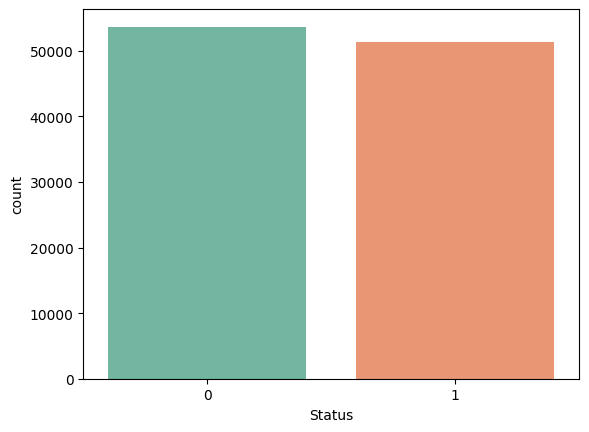

In [ ]:
# resampled ytrain
import seaborn as sns

sns.countplot(x=y_train, palette='Set2')